In [ ]:
import pandas as pd
import yaml
from pathlib import Path

from experiments import get_experiments_root_path
from models.base import get_models_root_path
from config import Config, global_config
from visuals import plot_precision_recall_curve, plot_counts_vs_threshold, plot_label_counts

In [2]:
exp_name = 'values-11_vs_ud_wk-top10'

In [3]:
config_path = get_experiments_root_path() / exp_name / f'{exp_name}__conf.yaml'
with open(config_path) as config_file:
	exp = Config(yaml.safe_load(config_file))

In [4]:
dict_names = [d.name for d in exp.dictionaries]

In [5]:
def load_test_out(d_name: str) -> pd.DataFrame:
	path = get_models_root_path() / f'{exp_name}__{exp_name}_{d_name}' / f'{exp_name}__{exp_name}_{d_name}__test_out.csv'
	return pd.read_csv(path, index_col=0)

tests_labeled = {d_name: load_test_out(d_name) for d_name in dict_names}

In [6]:
def load_labeled_dict(d_name: str) -> pd.DataFrame:
	path = Path(global_config.storage.root) / global_config.storage.labeled_out / exp_name / f'{d_name}.csv'
	df = pd.read_csv(path, index_col=0)
	df = df[pd.isna(df.label)]
	if 'quality' in df:
		df = df[df.quality > 0]
	df = df.sort_values(by='prob_out', ascending=False).groupby(by='word', as_index=False).head(1)
	return df
labeled_dicts = {d_name: load_labeled_dict(d_name) for d_name in dict_names}

### Training set record count

In [7]:
{name: f'{d.train_count:,}' for name, d in zip(dict_names, exp.datasets)}

{'urban_dictionary': '2,198', 'wiktionary': '3,158'}

### F-score

In [8]:
{d_name: f'{r.f_score:.2f}' for d_name, r in zip(dict_names, exp.results)}

{'urban_dictionary': '0.71', 'wiktionary': '0.68'}

### Precision

In [9]:
{d_name: f'{r.report["macro avg"].precision:.2f}' for d_name, r in zip(dict_names, exp.results)}

{'urban_dictionary': '0.69', 'wiktionary': '0.68'}

### Recall

In [10]:
{d_name: f'{r.report["macro avg"].recall:.2f}' for d_name, r in zip(dict_names, exp.results)}

{'urban_dictionary': '0.75', 'wiktionary': '0.70'}

### Accuracy

In [11]:
{d_name: f'{r.accuracy:.2f}' for d_name, r in zip(dict_names, exp.results)}

{'urban_dictionary': '0.71', 'wiktionary': '0.66'}

### Precision/Recall Curves

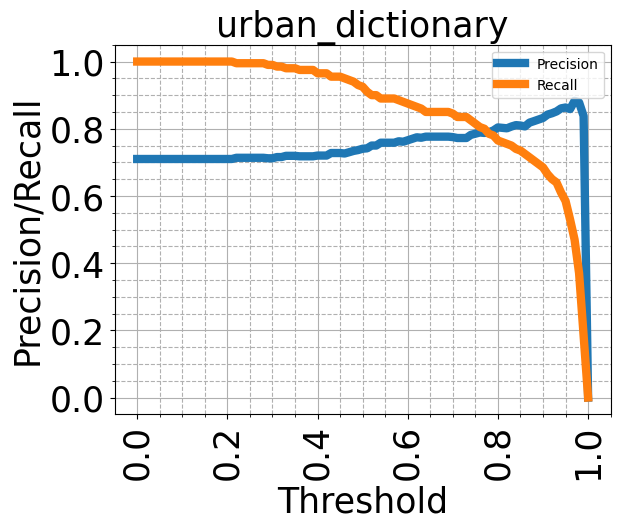

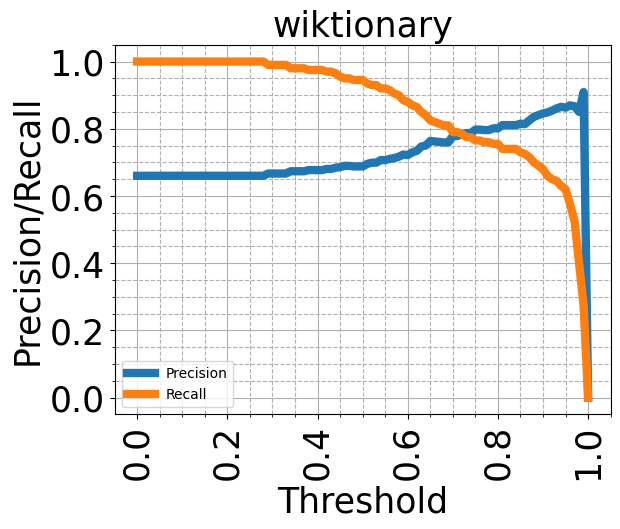

In [12]:
thr_pr_recalls = {d_name: plot_precision_recall_curve(df, title=d_name) for d_name, df in tests_labeled.items()}

### New terms count versus model confidence

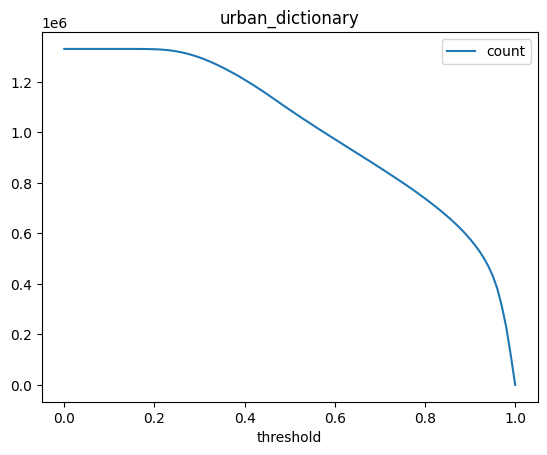

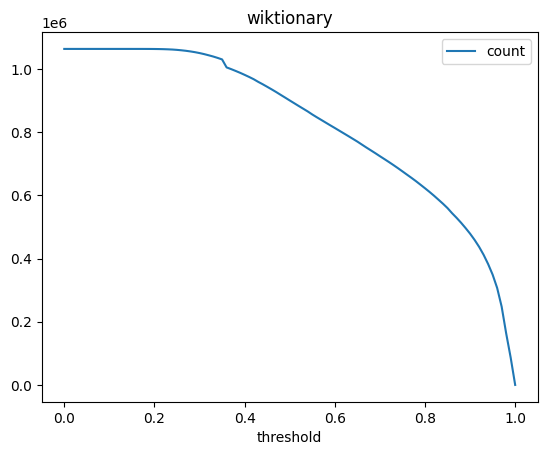

In [13]:
counts_vs_thresholds = {d_name: plot_counts_vs_threshold(df, title=d_name) for d_name, df in labeled_dicts.items()}

### Summary

In [14]:
prob_thr = 0.98

In [15]:
def print_stats(d_name: str, thr: float):
	pr, recall = thr_pr_recalls[d_name][thr]
	new_count = counts_vs_thresholds[d_name][thr]
	print(f'{d_name}: Precision {pr:.2f} Recall: {recall:.2f} New terms count {new_count:,}')
	df = labeled_dicts[d_name]
	df = df[df.prob_out >= thr]
	plot_label_counts(df.label_out, title=d_name)

urban_dictionary: Precision 0.88 Recall: 0.37 New terms count 230,545


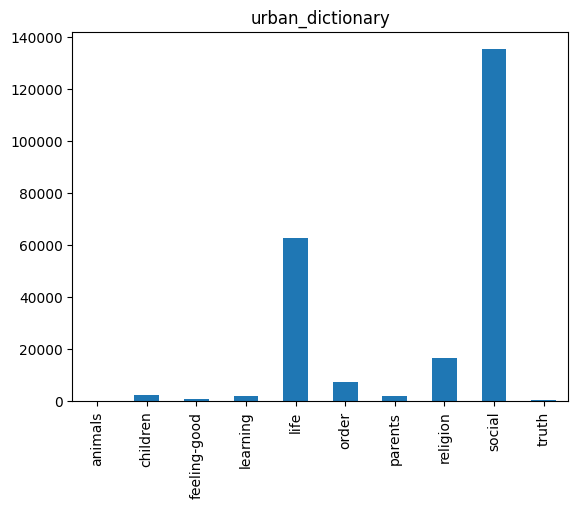

In [16]:
print_stats('urban_dictionary', prob_thr)

wiktionary: Precision 0.85 Recall: 0.40 New terms count 163,477


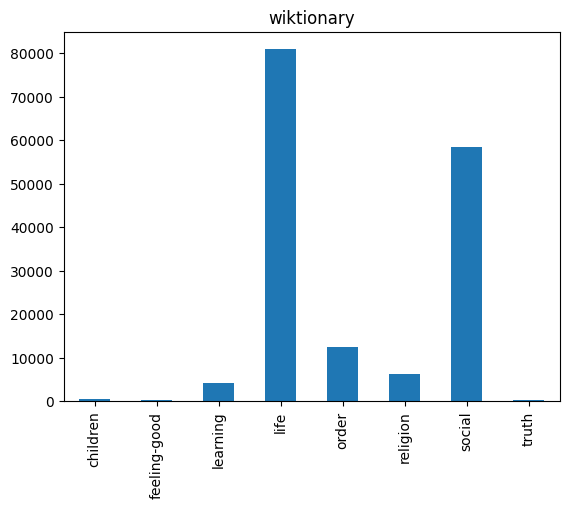

In [17]:
print_stats('wiktionary', prob_thr)